In [1]:
import math
import numpy as np
import sys
import cv2
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [2]:
input_filename = "data/LAMP_80s_240mpp_ratio_albed_01.img"
shape = (2501, 2501) # matrix size
dtype = np.float32 # big-endian unsigned integer (16bit)
output_filename = "LAMP_BRITE.PNG"

In [3]:
height = np.reshape(np.fromfile(open("data/LDEM_75S_120M.IMG",
                                     'rb'), np.int16),
                    (7624,7624))
albedo = np.reshape(np.fromfile(open("data/LDAM_50S_1000M_FLOAT.IMG",
                                     'rb'), np.float32),
                    (2532,2532))
LAMP_ratio_albed = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_albed_01.img",
                                     'rb'), np.float32),
                    (2501,2501))
LAMP_ratio_brite = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_brite_01.img",
                                     'rb'), np.float32),
                    (2501,2501))

In [4]:
height = height[1311:-1311,1311:-1311]
albedo = albedo[966:-966,966:-966]

lamp_brite = cv2.resize(LAMP_ratio_brite, dsize=height.shape)
lamp_albed = cv2.resize(LAMP_ratio_albed, dsize=height.shape)
albedo = cv2.resize(albedo, dsize=height.shape)

In [5]:
threshold_albedo = 0.35
threshold_lamp_ratio = 1.2

In [6]:
image = albedo > threshold_albedo

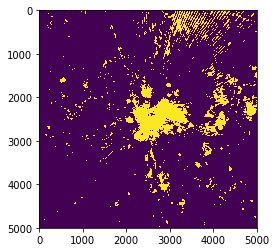

In [7]:
plt.imshow(image)
#plt.savefig(output_filename)
plt.show()

In [8]:
POI = ((lamp_albed > threshold_lamp_ratio) & 
        (lamp_brite > threshold_lamp_ratio) & 
        (albedo > threshold_albedo))

/Users/gschardong/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [9]:
km_per_px = 0.12
rover_max_dist_km = 24
rover_max_dist_px = rover_max_dist_km / km_per_px

In [10]:
%%time
from multiprocessing import Pool
from itertools import product


def process_roi(params_tup):
    i, j = params_tup
    ks = kern_size * kern_size
    count = POI[i:i+kern_size, j:j+kern_size].sum()
    prob = count / ks
    return count, prob, i, j


kern_size = int(rover_max_dist_px)
x, y = POI.shape[0] - kern_size, POI.shape[1] - kern_size
params = product(np.arange(x), np.arange(y))
POI_prob = np.zeros((x, y))
POI_count = np.zeros((x, y))

with Pool(processes=4) as p:
    results = p.map_async(process_roi, params).get()
    for r in results:
        count, prob, i, j = r
        POI_prob[i, j] = prob
        POI_count[i, j] = count

np.save('POI_prob.npy', POI_prob)
np.save('POI_count.npy', POI_count)

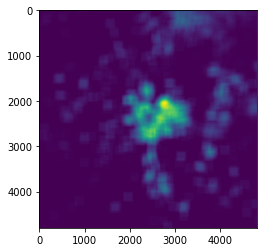

In [11]:
plt.imshow(POI_count)
plt.show()

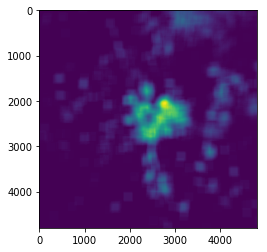

In [12]:
plt.imshow(POI_prob)
plt.show()